# DATA ENGINEERING: Stock Prediction

* HCMUT-VNU
* Semester: 231
* Group 17

# 0. Get data

In [ ]:
!python3.10 crawl-data.py

# 1. Data fields

There are some data fields that VN30 provided. They are described as below:

+ Ngày: Gồm ngày tháng năm cụ thể.

+ Lần cuối: Hay còn gọi là "Giá đóng"(close price), có nghĩa là giá cổ phiếu của phiên giao dịch cuối của ngày đó.

+ Mở: Hay còn gọi là "Giá mở"(open price), có nghĩa là giá cổ phiếu của phiên giao dịch đầu của ngày đó.

+ Cao: Hay còn gọi là "Giá trần", có nghĩa là giá cổ phiếu cao nhất trong ngày.

+ Thấp: Hay còn gọi là "Giá sàn", có nghĩa là giá cổ phiếu thấp nhất trong ngày.

+ KL: Số lượng giao dịch trong ngày của cổ phiếu.

+ % Thay đổi: Phần trăm thay đổi của giá đóng của ngày hôm sau so với ngày hiện tại.


Also, there are some fields that we can derive:

## RSI 
- Đây là "Chỉ số sức mạnh tương đối"(Relevant Strength Index) là giá trị phản ánh tình trạng quá "mua" hoặc quá "bán" trên thị trường. Có công thức như sau:

$$RSI=100-[\dfrac{100}{1+\dfrac{\text{Mức tăng trung bình}}{\text{Tổn thất trung bình}}}]$$

- Giá trị của RSI được biểu diễn trong khoảng từ 0 đến 100. Thông thường:

    + Nếu RSI > 70, thì cổ phiếu đang bị mua quá mức dẫn đến việc xu hướng tăng của giá trị cổ phiếu có khả năng bị giảm và xu hướng giảm có khả năng tăng.

    + Nếu RSI < 30, thì cổ phiếu đang bị bán quá mức dẫn đến giá trị cổ phiếu gần chạm đáy và chuẩn bị tăng.
    
    + Nếu RSI giữa khoảng (30,70) được coi là trung tính. Ví dụ với mức RSI=50 thì xem là không có xu hướng.

- Bên cạnh việc thể hiện tình trạng quá bán hoặc quá mua, nhà đầu tư cũng có thể sử dụng phân kỳ RSI để dự đoán xu hướng đảo chiều. Sự phân kỳ xảy ra khi giá chứng khoán di chuyển theo hướng ngược lại so với các chỉ báo kỹ thuật. Điều này cảnh báo xu hướng giá hiện tại có thể đang suy yếu và nguy cơ dẫn đến sự thay đổi hướng của giá. Trong đó có hai loại là phân kỳ âm và phân kỳ dương:

    + Phân kỳ dương: RSI tăng tạo đáy cao trong khi giá giảm tạo đáy thấp, cảnh báo đà tăng mạnh bất chấp xu hướng giá giảm.

    + Phân kỳ âm: RSI giảm và tạo đỉnh thấp trong khi giá tài sản tăng tạo đỉnh cao hơn, cảnh báo giá có thể giảm mạnh.


## EMA

- Đây là "Đường trung bình động luỹ thừa"(Exponent Moving Average). Nó được dùng để phản ánh sự biến động giá được tính theo cấp số nhân, qua đó giúp nhà đầu tư xác định được sự biến động giá một cách chuẩn xác hơn và giảm thiểu được tình trạng nhiễu giá so với đường trung bình động thông thường. 

- Có công thức:

$$\text{EMA}(t)=P(t) \times K + \text{EMA}(t-1) \times (1-K)$$

- Với:

    + $P(t)$: giá đóng của cổ phiếu ở ngày t.
 
    + $K=\dfrac{2}{1+N}$: hệ số làm trơn, được tính bằng công thức đính kèm với N là chu kì (ví dụ như 5 ngày, 10 ngày,...).
 
    + EMA(t): giá trị EMA tại ngày t.

- Sự di chuyển của đường EMA phản ánh xu hướng dịch chuyển của giá, thông qua đó nhà đầu tư nắm bắt tình hình xu hướng giá ngay thời điểm hiện tại.

- Đường EMA dốc lên thể hiện giá đang đi lên, thị trường trong xu hướng tăng. Ngược lại, đường EMA dốc xuống thể hiện giá đang đi xuống, thị trường trong xu hướng giảm. Đường EMA nằm ngang đồng nghĩa với giá cũng đi ngang, thị trường trong trạng thái sideway.

- EMA được theo 3 khung thời gian gồm có:

    + EMAF: EMA nhanh, thường tương ứng với các chu kỳ nhỏ.
    
    + EMAM: EMA trung bình, thường tương ứng với các chu kỳ trung bình.
    + EMAS: EMA chậm, thường tương ứng với chu kỳ lớn.

- Dựa vào sự cắt nhau của các đường EMAF, EMAM, EMAS và đường giá, ta sẽ xác định được xu hướng tăng hoặc giảm của cổ phiếu đó.

# 2. Data processing

## PRE-PROCESING FOR **VN30** FIRST, THEN WE CAN APPLY THE PRE-PROCESSING STEP FOR **VNI** AND **HNX30**

### Import Libraries

In [183]:
# !pip3 install numpy matplotlib yfinance
# !pip3 install -U git+https://github.com/twopirllc/pandas-ta.git@development
# !pip3 install seaborn
# !pip3 install plotly
# !pip3 install nbformat
# !pip3 install scipy

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import pandas_ta as ta
import yfinance as yf
import seaborn as sns

### Import data

In [3]:
data_VN30 = pd.read_csv('./VN30_311222-010113.csv') # there are no null values in this CSV file
data_HNX30 = pd.read_csv('./HNX30_311222-010113.csv')
data_VNI = pd.read_csv('./VN_311222-010113.csv')

In [4]:
data_VN30.head(5)

Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0  30/12/2022  1,005.19  1,016.71  1,017.45  1,005.19   95.62K     -0.31%
1  29/12/2022  1,008.30  1,013.95  1,022.15  1,008.30  121.03K     -0.56%
2  28/12/2022  1,013.95  1,009.19  1,023.24    997.12  123.26K      0.65%
3  27/12/2022  1,007.36    988.87  1,015.01    985.67  153.66K      1.98%
4  26/12/2022    987.77  1,032.42  1,033.17    987.77  175.23K     -4.48%

In [5]:
data_HNX30.head(5)

Ngày  Lần cuối      Mở     Cao    Thấp      KL % Thay đổi
0  31/01/2023    387.57  379.14  387.57  376.27  59.79K      2.36%
1  30/01/2023    378.63  378.74  387.43  374.18  72.88K     -0.06%
2  27/01/2023    378.87  379.27  387.81  378.20  46.37K     -0.02%
3  19/01/2023    378.94  373.53  379.98  373.04  51.80K      1.45%
4  18/01/2023    373.53  365.94  375.36  365.94  57.66K      1.98%

In [6]:
data_VNI.head(5)

Ngày  Lần cuối        Mở       Cao      Thấp       KL % Thay đổi
0  30/12/2022  1,007.09  1,009.29  1,017.99  1,007.09  407.14K     -0.22%
1  29/12/2022  1,009.29  1,015.66  1,021.96  1,009.29  462.66K     -0.63%
2  28/12/2022  1,015.66  1,004.57  1,020.52    998.97  590.45K      1.10%
3  27/12/2022  1,004.57    985.21  1,007.88    983.67  593.36K      1.97%
4  26/12/2022    985.21  1,020.34  1,021.89    985.21  623.49K     -3.44%

### Rename columns

Change to avoid using utf-8 character.

In [7]:
def rename(data):
    data.rename(columns={
        'Ngày': 'Date', 
        'Lần cuối': 'Close',
        'Mở': 'Open',
        'Cao': 'High',
        'Thấp': 'Low',
        'KL': 'Vol',
        '% Thay đổi': 'Percentage Change'
        }, 
        inplace=True)
    return data

In [8]:
data_VN30 = rename(data_VN30)

In [9]:
data_VN30.head(3)

Date     Close      Open      High       Low      Vol   
0  30/12/2022  1,005.19  1,016.71  1,017.45  1,005.19   95.62K  \
1  29/12/2022  1,008.30  1,013.95  1,022.15  1,008.30  121.03K   
2  28/12/2022  1,013.95  1,009.19  1,023.24    997.12  123.26K   

  Percentage Change  
0            -0.31%  
1            -0.56%  
2             0.65%

### As we can see, our data is being reversed

In [10]:
def reverseData(data):
    data = data.iloc[::-1]
    data.reset_index(drop=True, inplace=True)
    return data

In [11]:
data_VN30 = reverseData(data_VN30)
data_VN30

Date     Close      Open      High       Low      Vol   
0     02/01/2013    490.82    486.41    492.29    485.37   22.64K  \
1     03/01/2013    491.34    492.55    492.55    483.84   32.69K   
2     04/01/2013    498.31    489.71    499.85    487.95   20.15K   
3     07/01/2013    509.18    500.58    509.61    498.54   26.03K   
4     08/01/2013    525.36    512.41    525.36    511.64   32.89K   
...          ...       ...       ...       ...       ...      ...   
2491  26/12/2022    987.77  1,032.42  1,033.17    987.77  175.23K   
2492  27/12/2022  1,007.36    988.87  1,015.01    985.67  153.66K   
2493  28/12/2022  1,013.95  1,009.19  1,023.24    997.12  123.26K   
2494  29/12/2022  1,008.30  1,013.95  1,022.15  1,008.30  121.03K   
2495  30/12/2022  1,005.19  1,016.71  1,017.45  1,005.19   95.62K   

     Percentage Change  
0                1.12%  
1                0.11%  
2                1.42%  
3                2.18%  
4                3.18%  
...                ...  
2491            -4.48%  
2492             1.98%  
2493             0.65%  
2494            -0.56%  
2495            -0.31%  

[2496 rows x 7 columns]

### Get data types:

In [12]:
data_VN30.dtypes

Date                 object
Close                object
Open                 object
High                 object
Low                  object
Vol                  object
Percentage Change    object
dtype: object

In [13]:
data_VN30.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2496 entries, 0 to 2495
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Date               2496 non-null   object
 1   Close              2496 non-null   object
 2   Open               2496 non-null   object
 3   High               2496 non-null   object
 4   Low                2496 non-null   object
 5   Vol                2496 non-null   object
 6   Percentage Change  2496 non-null   object
dtypes: object(7)
memory usage: 136.6+ KB


As we can see, **Open**, **Close**, **High**, **Low** price got the same string format, but how about **Vol** ?

In [14]:
data_VN30['Vol'].str[-1].value_counts()

Vol
K    2491
M       5
Name: count, dtype: int64

There are 2 different values in **Vol**:
- K: Increase 1000 times.
- M: Increase 1000_000 times.

Convert data types:

In [15]:
def convertDataType(data):
    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')

    data['Close'] = data['Close'].astype(str)
    data['Open'] = data['Open'].astype(str)
    data['High'] = data['High'].astype(str)
    data['Low'] = data['Low'].astype(str)

    data['Close'] = pd.to_numeric(data['Close'].str.replace(',',''))
    data['Open'] = pd.to_numeric(data['Open'].str.replace(',',''))
    data['High'] = pd.to_numeric(data['High'].str.replace(',',''))
    data['Low'] = pd.to_numeric(data['Low'].str.replace(',',''))

    data['Percentage Change'] = data['Percentage Change'].str.replace('%', '')
    data['Percentage Change'] = pd.to_numeric(data['Percentage Change']) # if null then NaN

    # Convert Volume
    data['Vol'] = data['Vol'].astype(str)
    for i in range(len(data['Vol'])):
        if data['Vol'].loc[i][-1] == 'K':
            data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
            data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
        else: 
            data['Vol'].loc[i] = data['Vol'].loc[i].replace('M','')
            data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000000)
    data['Vol'] = data['Vol'].astype(int)

    return data 

In [16]:
data_VN30 = convertDataType(data_VN30)

/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_1491/3790775058.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_1491/3790775058.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_1491/3790775058.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [70]:
data_VN30.dtypes

Date                 datetime64[ns]
Close                       float64
Open                        float64
High                        float64
Low                         float64
Vol                           int64
Percentage Change           float64
dtype: object

## Now do the same for **VNI** and **HNX30**:

In [17]:
# rename
data_VNI = rename(data_VNI)
data_HNX30 = rename(data_HNX30)
# reverse
data_VNI = reverseData(data_VNI)
data_HNX30 = reverseData(data_HNX30)
# convert
data_VNI = convertDataType(data_VNI)
data_HNX30 = convertDataType(data_HNX30)

/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_1491/3790775058.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_1491/3790775058.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
/var/folders/97/qq731g4565sbxx06ghqh1ryr0000gn/T/ipykernel_1491/3790775058.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

## Descriptive stastistics

In [18]:
data_VN30.describe().T

count                           mean                  min   
Date                 2496  2018-01-06 21:46:43.846153728  2013-01-02 00:00:00  \
Close              2496.0                     853.710541               490.82   
Open               2496.0                     853.719988               486.41   
High               2496.0                     859.760405               492.29   
Low                2496.0                      847.19234               483.84   
Vol                2496.0                  136499.495192               6710.0   
Percentage Change  2496.0                        0.03643                -6.73   

                                   25%                  50%   
Date               2015-07-14 18:00:00  2018-01-03 12:00:00  \
Close                         617.9025               790.59   
Open                            618.03              790.745   
High                          621.8675              795.505   
Low                           614.2125              786.005   
Vol                            37320.0              52935.0   
Percentage Change                -0.51                 0.11   

                                   75%                  max            std  
Date               2020-07-08 06:00:00  2022-12-30 00:00:00            NaN  
Close                          973.885              1572.46     288.461699  
Open                           971.905              1576.52     288.653138  
High                          981.3375               1587.0     291.021923  
Low                            966.425              1567.67     285.634509  
Vol                            98347.5           34390000.0  1286973.97541  
Percentage Change               0.6725                 5.31       1.205359

In [19]:
data_VNI.describe().T

count                           mean                  min   
Date                 2496  2018-01-06 21:46:43.846153728  2013-01-02 00:00:00  \
Close              2496.0                     849.266595               418.35   
Open               2496.0                     849.247961                415.5   
High               2496.0                     854.845917               419.05   
Low                2496.0                     843.166378               413.68   
Vol                2496.0                  491994.002003              25840.0   
Percentage Change  2496.0                       0.042416                -6.67   

                                   25%                  50%   
Date               2015-07-14 18:00:00  2018-01-03 12:00:00  \
Close                         588.5225              829.045   
Open                          589.0275                827.8   
High                          591.8475               836.07   
Low                           585.7375               821.33   
Vol                           117507.5             175330.0   
Percentage Change                -0.44                 0.12   

                                   75%                  max             std  
Date               2020-07-08 06:00:00  2022-12-30 00:00:00             NaN  
Close                        1006.0275              1528.57      285.782573  
Open                          1006.185               1534.1      285.927427  
High                         1012.1925              1536.45      288.014713  
Low                            998.595              1524.96      283.122148  
Vol                           344542.5          121250000.0  4727753.337311  
Percentage Change               0.6525                 4.98        1.156728

In [20]:
data_HNX30.describe().T

count                           mean                  min   
Date                 2057  2018-12-16 23:22:11.842488832  2014-11-04 00:00:00  \
Close              2057.0                      271.73665               125.07   
Open               2057.0                     271.530462               124.58   
High               2057.0                     275.002154               127.51   
Low                2057.0                     268.323991               123.49   
Vol                2057.0                   33501.726787               5900.0   
Percentage Change  2057.0                       0.051415                 -8.2   

                                   25%                  50%   
Date               2016-11-24 00:00:00  2018-12-12 00:00:00  \
Close                           164.85               193.26   
Open                            164.53                193.2   
High                            166.53               194.83   
Low                             163.21               191.74   
Vol                            17280.0              26520.0   
Percentage Change                -0.65                 0.15   

                                   75%                  max           std  
Date               2020-12-31 00:00:00  2023-01-31 00:00:00           NaN  
Close                            299.9               874.02    172.202553  
Open                            299.59               874.02    172.198999  
High                            304.76               892.18    175.128033  
Low                             291.47               851.04     169.48012  
Vol                            43030.0             162660.0  22546.141237  
Percentage Change                 0.85                 6.98      1.630779

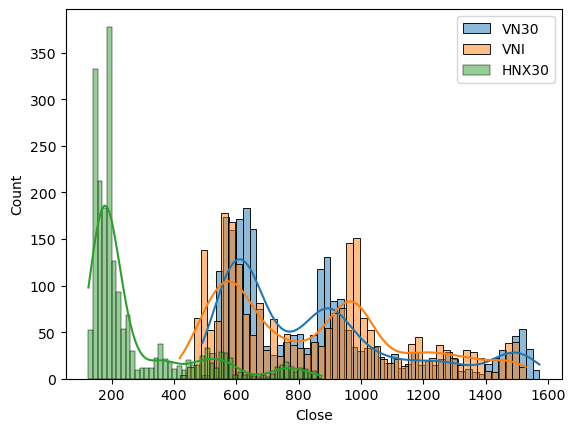

In [21]:
# Create a figure and axis
fig, ax = plt.subplots()

# Plot the first distribution
sns.histplot(data_VN30['Close'], bins=50, kde=True, ax=ax, label='VN30')
# Plot the second distribution on the same axis
sns.histplot(data_VNI['Close'], bins=50, kde=True, ax=ax, label='VNI')
# Plot the third distribution on the same axis
sns.histplot(data_HNX30['Close'], bins=50, kde=True, ax=ax, label='HNX30')
# Add a legend
ax.legend()
# Show the plot
plt.show()

### Number of record of each year from 01/01/2013 to 31/12/2022:

In [22]:
def volumePlot(data):
    vols = []
    for i in range (2013,2023):
        print(i,data[data['Date'].dt.year==i].size)
        vols += [[i,data[data['Date'].dt.year==i].size]]
    vols = pd.DataFrame({
    'Year': [vols[i][0] for i in range(len(vols))],
    'NumberOfTrades': [vols[i][1] for i in range(len(vols))]
    } )
    sns.barplot(vols, x="Year", y="NumberOfTrades")


2013 0
2014 294
2015 1736
2016 1757
2017 1750
2018 1750
2019 1750
2020 1764
2021 1750
2022 1736


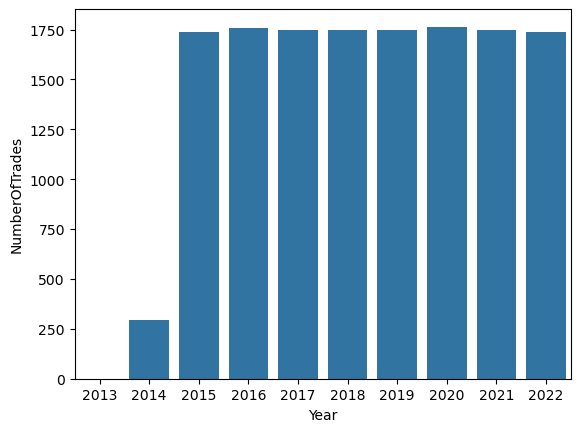

In [23]:
volumePlot(data_HNX30)

2013 1750
2014 1729
2015 1736
2016 1757
2017 1750
2018 1743
2019 1750
2020 1764
2021 1750
2022 1743


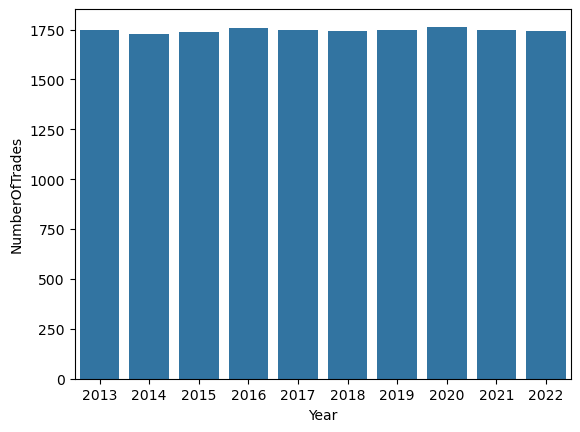

In [24]:
volumePlot(data_VN30)

2013 1750
2014 1729
2015 1736
2016 1757
2017 1750
2018 1743
2019 1750
2020 1764
2021 1750
2022 1743


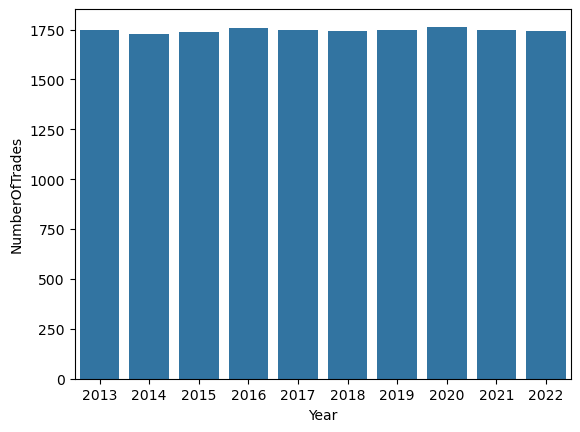

In [25]:
volumePlot(data_VNI)

### Attributes Distribution

In [26]:
def attributeDistributionPlot(data):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Price-related attributes box plots
    sns.boxplot(x="variable", y="value", data=pd.melt(data[['Close', 'Open', 'High', 'Low']]), ax=axes[0])
    axes[0].set_title('Price-related Attributes')

    # 'Volume' box plot
    sns.boxplot(x="Vol", data=data, ax=axes[1])
    axes[1].set_title('Volume')

    plt.tight_layout()
    plt.show()


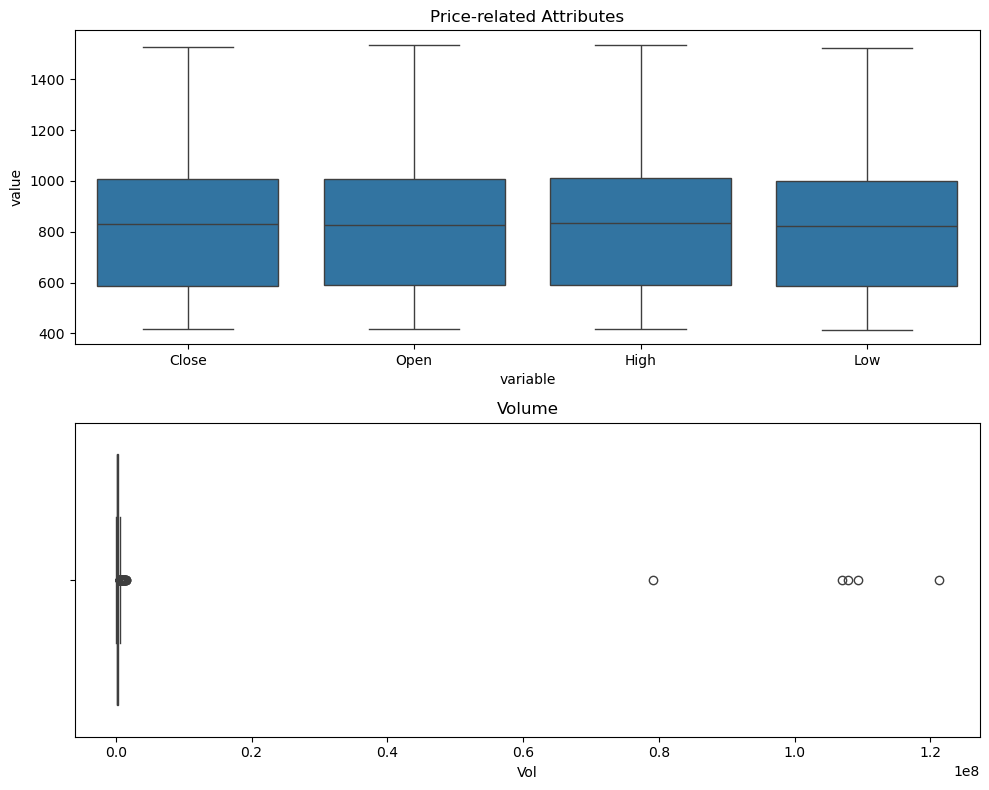

In [27]:
attributeDistributionPlot(data_VNI)

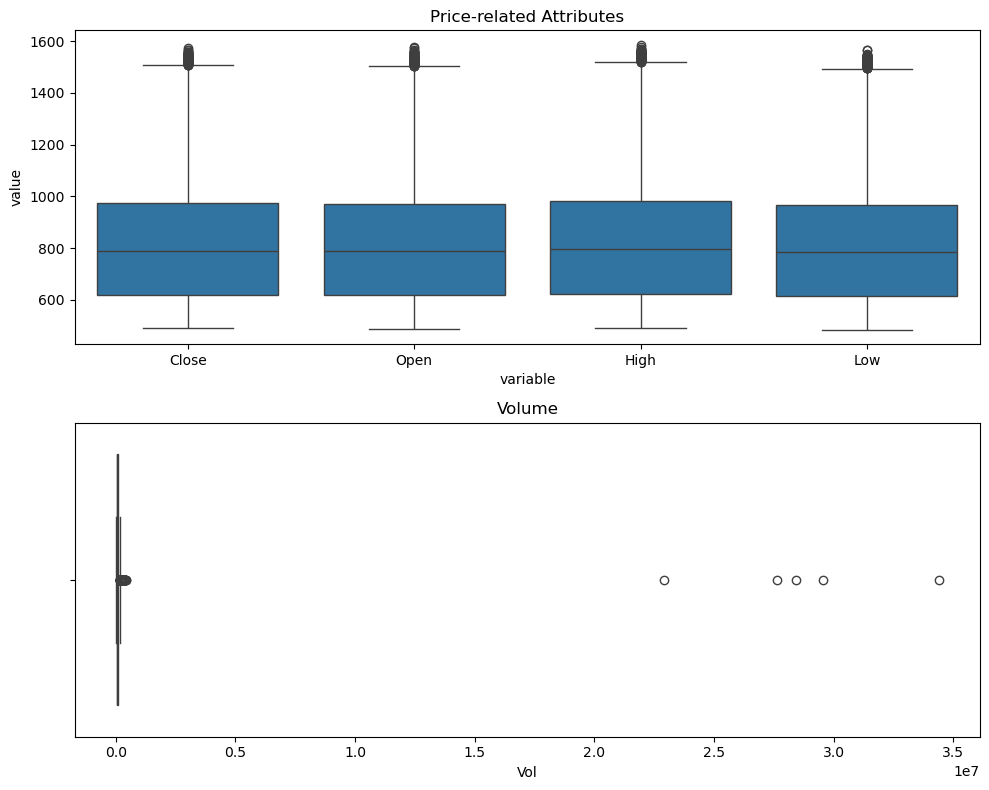

In [28]:
attributeDistributionPlot(data_VN30)

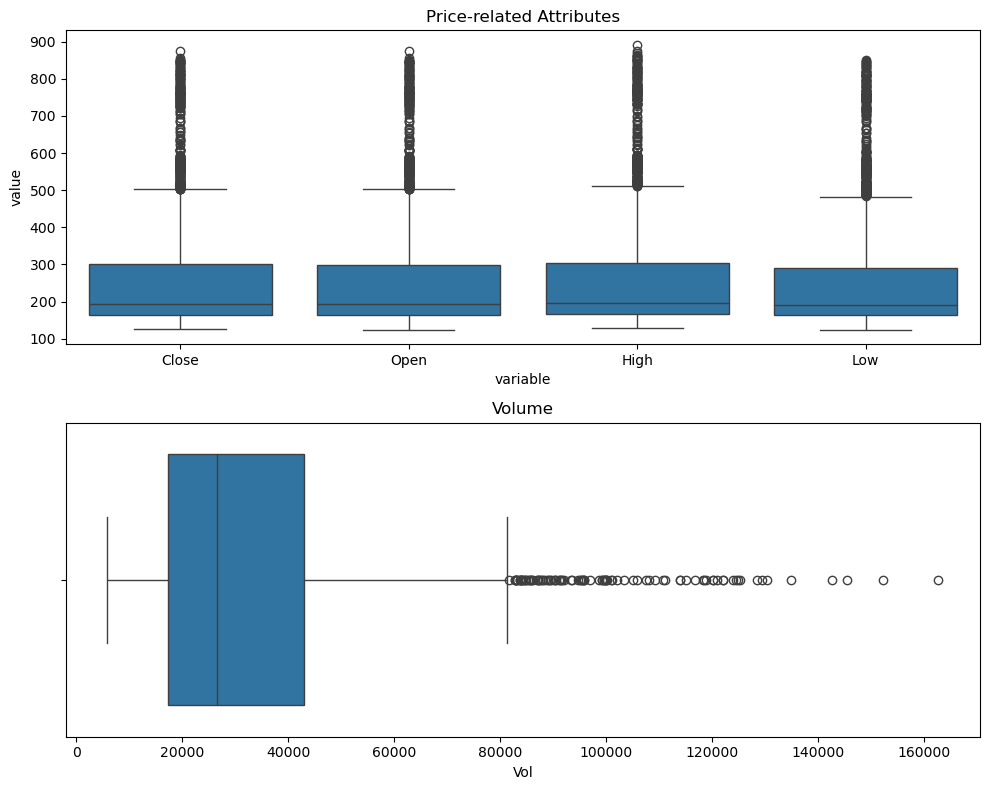

In [29]:
attributeDistributionPlot(data_HNX30)

## Check if there is outlier?

In [30]:
def detect_outliers(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1

    lower_bound = q1 - 3 * iqr
    upper_bound = q3 + 3 * iqr
    outliers = [(index, value) for index, value in enumerate(data) if value < lower_bound or value > upper_bound]
    return outliers

### Close

In [31]:
outliers_HNX30 = detect_outliers(data_HNX30.Close)
len(outliers_HNX30)

109

In [34]:
outliers_VN30 = detect_outliers(data_VN30.Close)
len(outliers_VN30)

0

In [35]:
outliers_VNI = detect_outliers(data_VNI.Close)
len(outliers_VNI)

0

### Volume

In [36]:
outliers_HNX30 = detect_outliers(data_HNX30.Vol)
len(outliers_HNX30)

15

In [37]:
outliers_VN30 = detect_outliers(data_VN30.Vol)
len(outliers_VN30)

38

In [38]:
outliers_VNI = detect_outliers(data_VNI.Vol)
len(outliers_VNI)

43

Because of stock attribute, We don't delete these outliers.

## Candlesticks

In [40]:
import plotly.graph_objects as go

def candlestick_plot(data):
    fig = go.Figure(data=[go.Candlestick(x=data['Date'],
                    open=data['Open'],
                    high=data['High'],
                    low=data['Low'],
                    close=data['Close'])])
    fig.show()

def candlestick_plot_from_to(data, from_year=2013, to_year=2023):
    for i in range(from_year, to_year):
        subset = data[data['Date'].dt.year == i]
        candlestick_plot(subset)

In [41]:
candlestick_plot_from_to(data_HNX30)

In [42]:
candlestick_plot_from_to(data_VN30)

In [43]:
candlestick_plot_from_to(data_VNI)

### Number of trade for each day (of week):

In [44]:
def numOfTradeEachDay(data):
    df = data.copy()
    df['dayofweek'] = df['Date'].dt.dayofweek
    print(df.groupby('dayofweek').agg({'Vol':['sum']}))

In [45]:
numOfTradeEachDay(data_VN30)

                Vol
                sum
dayofweek          
0          69340174
1          74621034
2          66371216
3          67129181
4          63241135


In [46]:
numOfTradeEachDay(data_VNI)

                 Vol
                 sum
dayofweek           
0          250771098
1          266102798
2          248013506
3          242849761
4          220279866


In [47]:
numOfTradeEachDay(data_HNX30)

                Vol
                sum
dayofweek          
0          13906058
1          14388877
2          13614634
3          13341294
4          13662189


As we can see, there are no Saturday and Sunday but there are lots of trade on Mon and Tues.

### Add Stock indicators

* RSI:

Choose t period:

In [48]:
def find_RSI_Period(data):
    for i in range(5,31):
        df = data.copy()
        df['RSI'] = ta.rsi(df.Close, length=i)
        df['NextClose'] = df['Close'].shift(-1)
        df.dropna(inplace=True)
        
        print(i,':',df['RSI'].corr(df['NextClose']))

In [49]:
find_RSI_Period(data_HNX30)

5 : 0.10473471151879489
6 : 0.10899879870728062
7 : 0.11296276054711525
8 : 0.11675982839316791
9 : 0.12044045493929156
10 : 0.1240246884488847
11 : 0.12752232044149128
12 : 0.13094029047876887
13 : 0.1342850499139761
14 : 0.1375630468012428
15 : 0.14078061856545784
16 : 0.14394378090102788
17 : 0.14705806788151063
18 : 0.15012844934486394
19 : 0.15315931017852824
20 : 0.15615446904454353
21 : 0.15911721821022135
22 : 0.1620503722709029
23 : 0.164956318615364
24 : 0.16783706591902436
25 : 0.17069428901746247
26 : 0.17352936964096102
27 : 0.1763434330450596
28 : 0.17913738080648675
29 : 0.1819119201257424
30 : 0.18466758997614677


HNX: 30 ngày

In [50]:
find_RSI_Period(data_VN30)

5 : 0.02312110456497428
6 : 0.024354190582291404
7 : 0.02550724790673899
8 : 0.02659809506937343
9 : 0.027620620163886687
10 : 0.02856580429449786
11 : 0.029430534429098404
12 : 0.030218979164786625
13 : 0.030940898553258354
14 : 0.031609287298352814
15 : 0.03223833347546586
16 : 0.03284195606677569
17 : 0.03343289069416946
18 : 0.034022202871254646
19 : 0.034619101597009996
20 : 0.035230947672704106
21 : 0.03586337787079464
22 : 0.03652048980925332
23 : 0.03720505096027726
24 : 0.03791870882199922
25 : 0.03866218879501803
26 : 0.039435472713364395
27 : 0.04023795513563354
28 : 0.041068577079899506
29 : 0.04192593838891915
30 : 0.04280839070299415


VN30: 30 ngày

In [51]:
find_RSI_Period(data_VNI)

5 : 0.028967521730602807
6 : 0.027228516925966412
7 : 0.02560598534166797
8 : 0.024057889837797112
9 : 0.022556175725399467
10 : 0.021079470193871103
11 : 0.0196137782895755
12 : 0.018152282481303426
13 : 0.016693850701510998
14 : 0.015241158916670824
15 : 0.013799008290768282
16 : 0.012373043056754908
17 : 0.0109688754817879
18 : 0.009591547617748315
19 : 0.008245243869695737
20 : 0.006933177370015846
21 : 0.005657589268259817
22 : 0.004419816050850359
23 : 0.003220393391896955
24 : 0.00205917535820065
25 : 0.0009354553725414812
26 : -0.0001519192826864885
27 : -0.00120444393610065
28 : -0.0022238660134225106
29 : -0.0032121079879589925
30 : -0.004171203270071745


VNI: 5 ngày

In [52]:
def addRSI(data, period=30):
    # RSI
    data['RSI'] = ta.rsi(data.Close, length=period)

In [53]:
addRSI(data_HNX30, 30)
addRSI(data_VN30, 30)
addRSI(data_VNI,5)

* EMA:

    - EMAF: 20 days
    - EMAM: 50 days
    - EMAS: 100 days

In [54]:
def addEMA(data):
    data['EMAF'] = ta.ema(data.Close, length=20)
    data['EMAM'] = ta.ema(data.Close, length=50)
    data['EMAS'] = ta.ema(data.Close, length=100)

In [55]:
addEMA(data_HNX30)
addEMA(data_VN30)
addEMA(data_VNI)

* VWAP:

In [ ]:
def addVWAP(data):
    data['average'] = (data['High'] + data['Low'] + data['Close'])/3
    data['vwap'] = (data['average'] * data['Vol'])/ data['Vol']

    # Percentage change of vwap:
    data['vwap_pct_ret'] = data['vwap'].pct_change()
    data['pvwap'] = data['vwap_pct_ret'].shift(-1)

In [ ]:
addVWAP(data_HNX30)
addVWAP(data_VN30)
addVWAP(data_VNI)

* Add Target Labels:

In [ ]:
'''
Target: Boolean value, 0 if the next closing price smaller than the current closing price.
'''
data['Target'] = (data['Close'] - data.Open).shift(-1) 

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Close'].shift(-1)


data.head()

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Vol', 'Date', "Percentage Change", "index",'average','dayofweek'], axis=1, inplace=True)
data.info()

pd.set_option('display.max_columns', None)

data.head(20)
#print(data_set.shape)
#print(data.shape)
#print(type(data_set))

### RSI Distribution

In [ ]:
def plotRSI(data):
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(4,4)})    
    sns.boxplot( y="RSI", data=data)
    plt.ylabel('RSI', fontsize=12)
    plt.xticks(rotation='vertical')
    plt.title("Distribution of RSI", fontsize=15)
    plt.show()

### Scale data by Scikit StandardScaler

In [ ]:
# !pip3 install scikit-learn

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
data_set = scaler.fit_transform(data)

In [ ]:
print(data_set)

In [ ]:
data_set.shape

### Create Dataset for training and testing

* X: Input set
* Y: Output set

Regression:

In [ ]:
X_regression = data_set[:,:10]
X_regression.shape

In [ ]:
y_regression =  data_set[:,-1]
y_regression.shape

Classification:

In [ ]:
X_classification = data_set[:,:10]
X_classification.shape

In [ ]:
y_classification = np.where(data_set[:,-1] > data_set[:,0], 1, 0)
y_classification.shape

LSTM:

In [ ]:
X = []
# print(data_set[0].size) # => 11
backcandles = 10
# print(data_set.shape[0]) # => 2346

# get all columns except "Target",	"TargetClass",	"TargetNextClose"
for i in range(10):
    X.append([])
    for j in range(backcandles, data_set.shape[0]):
        X[i].append(data_set[j-backcandles:j,i]) # get each "backcandles" element from each column.

print("0:",X[0][0:1]) # first candle set of Close Price
print("1:",X[1][0:1]) # first candle set of Open Price


In [ ]:
X = np.moveaxis(X,[0],[2]) # Transposition

In [ ]:
X[0][:3]

In [ ]:
X_lstm = np.array(X)
y_lstm = np.reshape(np.array(data_set[backcandles:,-1]), (len(np.array(data_set[backcandles:,-1])),1))# LSTM got output from "backcandle"
# 1 col, with len(X)-backcandles rows

In [ ]:
print("Shape",y_lstm.shape)
print(y_lstm)

Because of ReLU Activation Function:

In [ ]:
y_lstm = y_lstm + 2

### Split data

In [ ]:
splitlimit = int(len(X_lstm)*0.8)
print("Split lim:",splitlimit)

* Regression models train/test set:

In [ ]:
X_train_regression, X_test_regression = X_regression[:splitlimit], X_regression[splitlimit:]
y_train_regression, y_test_regression = y_regression[:splitlimit], y_regression[splitlimit:]
print("Xtrain shape",X_train_regression.shape)
print("Xtest shape",X_test_regression.shape)
print("ytrain",y_train_regression.shape)
print("ytest",y_test_regression.shape)

* Classification models train/test set:

In [ ]:
X_train_classification, X_test_classification = X_classification[:splitlimit], X_classification[splitlimit:]
y_train_classification, y_test_classification = y_classification[:splitlimit], y_classification[splitlimit:]
print("Xtrain shape",X_train_classification.shape)
print("Xtest shape",X_test_classification.shape)
print("ytrain",y_train_classification.shape)
print("ytest",y_test_classification.shape)

* LSTM train/test set:

In [ ]:
X_train_lstm, X_test_lstm = X_lstm[:splitlimit], X_lstm[splitlimit:]
y_train_lstm, y_test_lstm = y_lstm[:splitlimit], y_lstm[splitlimit:]
print("Xtrain shape",X_train_lstm.shape)
print("Xtest shape",X_test_lstm.shape)
print("ytrain",y_train_lstm.shape)
print("ytest",y_test_lstm.shape)

## Summary

In [ ]:
# csv file from https://vn.investing.com/indices
def pre_process(data):

    data = data.iloc[::-1]  # reverse list
    data.reset_index(drop=True, inplace=True)

    data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
    data['Close'] = pd.to_numeric(data['Close'].str.replace(',',''))
    data['Open'] = pd.to_numeric(data['Open'].str.replace(',',''))
    data['High'] = pd.to_numeric(data['High'].str.replace(',',''))
    data['Low'] = pd.to_numeric(data['Low'].str.replace(',',''))

    data['Percentage Change'] = data['Percentage Change'].str.replace('%', '')
    data['Percentage Change'] = pd.to_numeric(data['Percentage Change']) # if null then NaN

    data['Vol'] = data['Vol'].astype(str)
    data.dropna(inplace=True)
    for i in range(len(data['Vol'])):
        if data['Vol'].loc[i][-1] == 'K':
            data['Vol'].loc[i] = data['Vol'].loc[i].replace('K','')
            # print(data['Vol'].loc[i] )
            data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000)
        else: 
            data['Vol'].loc[i] = data['Vol'].loc[i].replace('M','')
            data['Vol'].loc[i] = int(float(data['Vol'].loc[i])*1000000)

    data['Vol'] = data['Vol'].astype(int)
    data['dayofweek'] = data['Date'].dt.dayofweek
    data['RSI'] = ta.rsi(data.Close, length=14)
    data['EMAF'] = ta.ema(data.Close, length=20)
    data['EMAM'] = ta.ema(data.Close, length=50)
    data['EMAS'] = ta.ema(data.Close, length=100)
    data['average'] = (data['High'] + data['Low'] + data['Close'])/3
    data['vwap'] = (data['average'] * data['Vol'])/ data['Vol']
    data['vwap_pct_ret'] = data['vwap'].pct_change()
    data['pvwap'] = data['vwap_pct_ret'].shift(-1)

    # TARGETS ===========================
    data['Target'] = (data['Close'] - data.Open).shift(-1) 
    data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]
    data['TargetNextClose'] = data['Close'].shift(-1)
    #  ===========================

    data.dropna(inplace=True)
    data.reset_index(inplace = True)
    data.drop(['Vol', 'Date', "Percentage Change", "index",'average', 'dayofweek'], axis=1, inplace=True)
    
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    return data

For Regression

In [ ]:
def process_regression(data):
    X_regression = data[:,:10]
    y_regression = data[:,-1]
    return X_regression, y_regression

For Classifications:

In [ ]:
def process_classification(data):
    X_classification = data[:,:10]
    y_classification = np.where(data[:,-1] > data[:,0], 1, 0)
    return X_classification, y_classification

For LSTM model:

In [ ]:
def process_lstm(data, backcandles):
    X = []
    for i in range(10):
        X.append([])
        for j in range(backcandles, data.shape[0]):
            X[i].append(data[j-backcandles:j,i]) # get each "backcandles" element from each column.

    X = np.moveaxis(X,[0],[2]) # Transposition
    X_lstm = np.array(X)
    y_lstm = np.reshape(np.array(data[backcandles:,-1]), (len(np.array(data[backcandles:,-1])),1))# LSTM got output from "backcandle"
    y_lstm += 2
    return (X_lstm, y_lstm)

def split_dataset(X, y):
    split = int(0.8 * len(X))
    X_train, y_train = X[:split,:], y[:split,:]
    X_test, y_test = X[split:,:], y[split:,:]
    return X_train, y_train, X_test, y_test

# 3. Models

# Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
linear_reg = LinearRegression().fit(X_train_regression, y_train_regression)

# SVM

### Import Library

In [ ]:
from sklearn.svm import SVC

### Fit SVM with train datasets

In [ ]:
# Support vector classifier 
cls = SVC().fit(X_train_classification, y_train_classification)

# SVR

In [ ]:
from sklearn.svm import SVR

In [ ]:
# Support vector regression 

#rgb
svm_reg_rgb = SVR().fit(X_train_regression, y_train_regression)
#linear
svm_reg_linear = SVR(kernel='linear').fit(X_train_regression, y_train_regression)
#poly
svm_reg_poly = SVR(kernel='poly').fit(X_train_regression, y_train_regression)

# LSTM 

## Background

Trong nhiều ứng dụng máy học, đặc biệt là trong xử lý dữ liệu chuỗi, việc duy trì và hiểu được mối quan hệ trong dữ liệu thời gian là quan trọng. Các mô hình truyền thống như mạng nơ-ron thuần (feedforward neural networks) thường không thể hiệu quả trong việc này do không giữ được thông tin liên tục qua thời gian.
 
LSTM là một dạng đặc biệt của mạng nơ-ron hồi quy (RNN - Recurrent Neural Network) được thiết kế để vượt qua vấn đề "mất mát thông tin" trong quá trình học dữ liệu thời gian.

### Forget Gate

LSTM sử dụng cổng quên để quyết định xem thông tin nào nên được giữ lại và thông tin nào nên bị loại bỏ từ bước thời gian trước đó.

$$\ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) \$$

$$\ C_t = f_t \odot C_{t-1} \$$

### Input Gate

Cổng đầu vào quyết định thông tin mới nào sẽ được thêm vào trạng thái ẩn.

$$\ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) \$$

$$ \tilde{C}_t = \tanh(W_c \cdot [h_{t-1}, x_t] + b_c) \$$

$$\ C_t = i_t \odot \tilde{C}_t \$$


### Output Gate

Cổng đầu ra quyết định thông tin nào sẽ được xuất ra từ trạng thái ẩn để làm đầu vào cho bước thời gian tiếp theo.

$$\ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) \$$

$$\ h_t = o_t \odot \tanh(C_t) \$$

Trong các công thức trên:

- $\mathbf{f}_t$, $\mathbf{i}_t$, $\mathbf{o}_t$ là các vectơ cổng quên, đầu vào, và đầu ra tương ứng.
- $\sigma$  là hàm sigmoid, $\tanh$ là hàm tanh.
- $\mathbf{W}_f$, $\mathbf{W}_i$, $\mathbf{W}_o$, $\mathbf{W}_c$ là ma trận trọng số cho các cổng và trạng thái ẩn.
- $\mathbf{h}_{t-1}$, $\mathbf{x}_t$ là vector kết hợp giữa trạng thái ẩn từ bước thời gian trước đó $\mathbf{h}_{t-1}$ và đầu vào $\mathbf{x}_t$.
- $\mathbf{b}_f$, $\mathbf{b}_i$, $\mathbf{b}_o$, $\mathbf{b}_c$ là các vectơ độ lệch (bias).

Các biến:

- $\mathbf{C}_t$ là trạng thái ẩn (cell state) tại thời điểm $t$.
- $\tilde{\mathbf{C}}_t$ là thông tin mới được đề xuất cho trạng thái ẩn.
- $\mathbf{h}_t$ là trạng thái ẩn đầu ra tại thời điểm $t$.
- $\odot$ đại diện cho phép nhân element-wise (tích vô hướng).

### Import Libraries

In [ ]:
# !pip3 install keras tensorflow

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
from sklearn.metrics import mean_squared_error
import numpy as np

### Layers

In [ ]:
# lstm_input = Input(shape=(backcandles, 11), name='lstm_input')
# inputs = LSTM(150, name='first_layer')(lstm_input)  
# inputs = Dense(1, name='dense_layer')(inputs)
# output = Activation('relu', name='output')(inputs)
# lstm_model = Model(inputs=lstm_input, outputs=output)
# adam = optimizers.Adam()
# lstm_model.compile(optimizer=adam, loss='mse')
# lstm_model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=20, epochs=40, shuffle=True, validation_split = 0.1)

In [ ]:
def create_lstm_model(backcandles, X_train_lstm, y_train_lstm):
    lstm_input = Input(shape=(backcandles, 10), name='lstm_input')
    inputs = LSTM(150, name='first_layer')(lstm_input)  
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('relu', name='output')(inputs)
    lstm_model = Model(inputs=lstm_input, outputs=output)
    adam = optimizers.Adam()
    lstm_model.compile(optimizer=adam, loss='mse')
    lstm_model.fit(x=X_train_lstm, y=y_train_lstm, batch_size=20, epochs=40, shuffle=True, validation_split = 0.1)
    return lstm_model

def evaluate_backcandles():
    results = []
    backcandles_values = [2*i for i in range(3,13)]
    for backcandles in backcandles_values:
        X_lstm, y_lstm = process_lstm(data=data_set,backcandles=backcandles)
        X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = split_dataset(X_lstm, y_lstm)

        print(f"Evaluating backcandles={backcandles}")
        model = create_lstm_model(backcandles, X_train_lstm, y_train_lstm)
        
        # Assuming you have X_test_lstm, y_test_lstm for evaluation
        y_pred = model.predict(X_test_lstm)
        mse = mean_squared_error(y_test_lstm, y_pred)
        results.append((backcandles, mse, model))
    return results

def get_best_backcandles(results):
    # results is an array wth triples (backcandles and mse and model)
    return min(results, lambda x: x[1])[:]

In [ ]:
result = (evaluate_backcandles())

In [ ]:
minimize = 1
idx = 2

for i in range(2,len(result)):
    if minimize > result[i][1]:
        minimize = result[i][1]
        idx = i


backcandles = 2*(i+1)
lstm_model = result[idx][2]

# 4. Model evaluation

Load new dataset

In [ ]:
new_dataset = pd.read_csv('VN30_150113-161202.csv')
new_dataset.info()

In [ ]:
np.where(pd.isnull(new_dataset.Vol))

There are just 4 days that have 0 trade. We can delete them and this will not affect much our dataset.

In [ ]:
new_dataset.drop(new_dataset[pd.isnull(new_dataset.Vol)].index,inplace=True)

In [ ]:
newdata = pre_process(new_dataset)

# Linear Regression

In [ ]:
y_pred_linear_reg = linear_reg.predict(X_test_regression)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_pred_linear_reg,color='blue',label='pred') 
plt.plot(y_test_regression,color='red',label='pred') 

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_pred_linear_reg,color='blue',label='pred') 

In [ ]:
plt.figure(figsize=(16,8)) 
plt.plot(y_test_regression,color='red',label='pred') 

In [ ]:
mean_squared_error(y_pred_linear_reg, y_test_regression)

### Try to predict new dataset

In [ ]:
X_newdata_linear, y_newdata_linear = process_regression(newdata)


In [ ]:
X_newdata_linear.shape

In [ ]:
y_newdata_linear.shape

In [ ]:
y_pred_newdata_linear = linear_reg.predict(X_newdata_linear)

In [ ]:
y_pred_newdata_linear.shape

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_newdata_linear, color = 'blue', label = 'Test')
plt.plot(y_pred_newdata_linear, color = 'red', label = 'pred')
plt.legend()
plt.show()

## SVM

Predict test dataset:

In [ ]:
y_pred_svm = cls.predict(X_test_classification)

Calculate **accuracy_score**:

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print(accuracy_score(y_pred_svm, y_test_classification))

In [ ]:
data_svm = data.copy()
data_svm['Predicted_Signal'] = cls.predict(X_classification)

data_svm['Signal'] = np.where(data_svm['TargetNextClose']>data_svm['Close'], 1, 0)

In [ ]:
print(accuracy_score(data_svm['Predicted_Signal'], data_svm['Signal']))

* Calculate daily returns:

In [ ]:
data_svm['Return'] = data_svm.Close.pct_change()

In [ ]:
data_svm.dropna(inplace=True)

* Calculate Strategy Returns:

In [ ]:
data_svm['Strategy_Return'] = data_svm.Return * data_svm.Predicted_Signal

* Calculate Cumulative Returns:

In [ ]:
data_svm['Cum_Ret'] = data_svm['Return'].cumsum() 

* Calculate Strategy Cumulative Returns:

In [ ]:
data_svm['Cum_Strategy'] = data_svm['Strategy_Return'].cumsum() 
data_svm

In [ ]:
def classification_evaluation(model, dataframe):
    data_svm = dataframe.copy()
    data_svm['Predicted_Signal'] = model.predict(data_svm[:,:11])
    data_svm['Signal'] = np.where(data_svm['TargetNextClose']>data_svm['Close'], 1, 0)
    data_svm['Return'] = data_svm.Close.pct_change()
    data_svm.dropna(inplace=True)
    data_svm['Strategy_Return'] = data_svm.Return * data_svm.Predicted_Signal
    data_svm['Cum_Ret'] = data_svm['Return'].cumsum() 
    data_svm['Cum_Strategy'] = data_svm['Strategy_Return'].cumsum() 

    plt.figure(figsize=(16,8))
    plt.plot(data_svm['Cum_Ret'],color='red',label= 'test') 
    plt.plot(data_svm['Cum_Strategy'],color='blue',label='pred')
    return

* Plot Strategy Returns vs Original Returns:

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data_svm['Cum_Ret'],color='red',label= 'test') 
plt.plot(data_svm['Cum_Strategy'],color='blue',label='pred')

In [ ]:
plt.figure(figsize=(16,8))


# SVR

In [ ]:
#rgb
y_pred_svr_rgb = svm_reg_rgb.predict(X_test_regression)

#linear
y_pred_svr_linear = svm_reg_linear.predict(X_test_regression)

#poly
y_pred_svr_poly = svm_reg_poly.predict(X_test_regression)

### RGB

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_regression, color = 'blue', label = 'Test')
plt.plot(y_pred_svr_rgb, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(y_pred_svr_rgb,y_test_regression)

### Linear

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_regression, color = 'blue', label = 'Test')
plt.plot(y_pred_svr_linear, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(y_pred_svr_linear,y_test_regression)

### Poly

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_regression, color = 'blue', label = 'Test')
plt.plot(y_pred_svr_poly, color = 'red', label = 'pred')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(y_pred_svr_poly,y_test_regression)

## LSTM

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred_lstm[i], y_test_lstm[i])

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_test_lstm, color = 'black', label = 'Test')
plt.plot(y_pred_lstm, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [ ]:
mean_squared_error(y_pred_lstm,y_test_lstm)

### Try to predict new dataset

In [ ]:
X_newdata_lstm, y_newdata_lstm = process_lstm(newdata, backcandles=backcandles)

In [ ]:
y_newdata_lstm

In [ ]:
y_pred_newdata_lstm = lstm_model.predict(X_newdata_lstm)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(y_newdata_lstm, color = 'black', label = 'Test')
plt.plot(y_pred_newdata_lstm, color = 'green', label = 'pred')
plt.legend()
plt.show()

# 5. References
1. https://vnexpress.net/chi-bao-rsi-la-gi-4481781.html